In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [ ]:
df_AI=pd.read_csv(r"../Rawdata/N_S_Treering_results_select.csv")
# === Step-by-step ===
grouped_summary_3 = (
    df_AI.groupby('Filename')  
    .filter(lambda df: len(df) >= 4)  
    .groupby('Filename') 
    .agg(
        Slope_P=('Slope', lambda x: (x > 0).mean()),  
        Mean=('Mean', 'mean')                 
    )
    .reset_index()  
)

In [3]:
import geopandas as gpd
df_siteg = gpd.read_file("../Rawdata/ITRDB_site.shp")
grouped_summary_3['site'] = grouped_summary_3['Filename'].str.replace('.rwl.csv', '', regex=False)
dfslope_3 = pd.merge(grouped_summary_3.loc[:,'Slope_P':],df_siteg.loc[:,['Latitude', 'Longitude', 'DEM','site','ai_v3','GMBA','Tree_Speci']])


d:\software\Anaconda3\envs\dataProcessing\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\2371515463.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. How

In [4]:
dfslope_3_N_P = dfslope_3[(dfslope_3['Latitude']>0)]
df_AI['site'] = df_AI['site'].str.lower()
dfslope_3_N_P['site'] = dfslope_3_N_P['site'].str.lower()
sites_of_interest = dfslope_3_N_P['site'].unique()
filtered_sig_df = df_AI[df_AI['site'].isin(sites_of_interest)]
summary_df = filtered_sig_df.groupby('site').agg({
    'Start_year': 'min',
    'End_year': 'max',
    'Mean': 'mean',
    'Prefix': pd.Series.nunique
}).reset_index()
summary_df = pd.merge(dfslope_3_N_P[['site']], summary_df, on='site', how='left')
df_site_allsite =pd.read_csv(r"../Rawdata/itrdb_dem_landconr_values.csv")
dfsite52itrdb = pd.merge(summary_df,df_site_allsite.loc[:,'Latitude':],on='site')
# dfsite52itrdb.to_csv(r'E:\experiment\ITRDB_kuang_zhai\Manuscipt\sitede.csv')

C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\2476999294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfslope_3_N_P['site'] = dfslope_3_N_P['site'].str.lower()


C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\3980888831.py:49: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


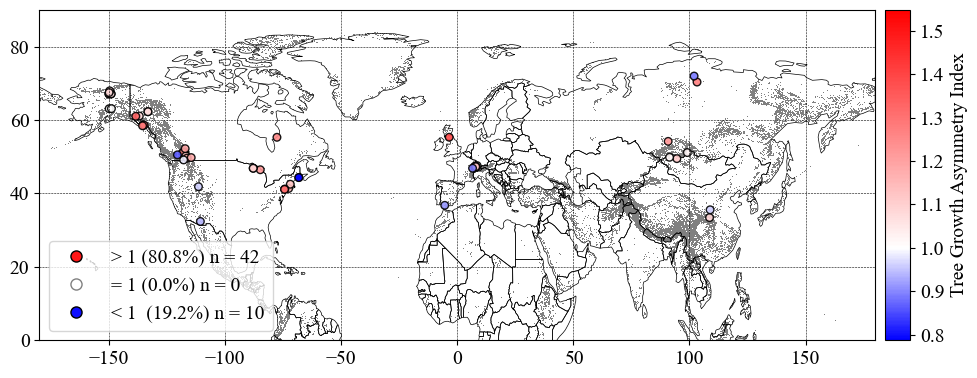

In [5]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import numpy as np
from matplotlib.lines import Line2D
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

tif_path = r"../Rawdat/GMBA_2021_MntnMask_EarthEnv_30s1Bit.tif"

with rasterio.open(tif_path) as src:
    mountain_mask = src.read(1)
    transform = src.transform
    bounds = src.bounds

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

mountain_cmap = ListedColormap(['white', 'gray'])

geometry = [Point(xy) for xy in zip(dfslope_3_N_P['Longitude'], dfslope_3_N_P['Latitude'])]
gdf = gpd.GeoDataFrame(dfslope_3_N_P, geometry=geometry, crs='EPSG:4326')

conditions = [
    gdf['Mean'] > 1,
    gdf['Mean'] < 1,
    gdf['Mean'] == 1
]
choices = ['> 1', '< 1', '= 1']
gdf['mean_class'] = np.select(conditions, choices, default='= 1')

gdf_gt = gdf[gdf['mean_class'] == '> 1']
gdf_lt = gdf[gdf['mean_class'] == '< 1']
gdf_eq = gdf[gdf['mean_class'] == '= 1']

total = len(gdf)
p_gt = f"({len(gdf_gt)/total*100:.1f}%) n = {len(gdf_gt)} "
p_lt = f" ({len(gdf_lt)/total*100:.1f}%) n = {len(gdf_lt)}"
p_eq = f"({len(gdf_eq)/total*100:.1f}%) n = {len(gdf_eq)}"

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

vmin = gdf['Mean'].min()
vcenter = 1
vmax = gdf['Mean'].max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = cm.bwr

fig, ax = plt.subplots(figsize=(10, 4))

ax.imshow(mountain_mask, cmap=mountain_cmap, extent=extent, interpolation='none')

world.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)


if not gdf_eq.empty:
    gdf_eq.plot(
        ax=ax,
        facecolor='white',
        edgecolor='gray',
        linewidth=1.2,
        markersize=20,
        label='= 1 ' + p_eq
    )

if not gdf_gt.empty:
    gdf_gt.plot(
        ax=ax,
        column='Mean',
        cmap=cmap,
        norm=norm,
        markersize=30,
        edgecolor='k',
        alpha=0.9
    )

if not gdf_lt.empty:
    gdf_lt.plot(
        ax=ax,
        column='Mean',
        cmap=cmap,
        norm=norm,
        markersize=30,
        edgecolor='k',
        alpha=0.9
    )


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=cax)
cb.set_label("Tree Growth Asymmetry Index")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'> 1 {p_gt}',
           markerfacecolor=cmap(norm(1.5)), markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'= 1 {p_eq}',
           markerfacecolor='white', markeredgecolor='gray', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'< 1 {p_lt}',
           markerfacecolor=cmap(norm(0.8)), markeredgecolor='k', markersize=8),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=14, frameon=True)
ax.set_xlim(-180, 180)
ax.set_ylim(0, 90)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
ax.set_aspect('auto')
ax.grid(True, linestyle='--', color='black', linewidth=0.4)

plt.tight_layout()
# plt.savefig(r'../Rawdat/Fig/Fig1-A.jpg', dpi=600, bbox_inches='tight')
plt.show()


In [6]:
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np


if not hasattr(np, "alen"):
    np.alen = lambda a: len(a)
# === paths ===
pre_path = r"../Rawdat/cru_ts4.07.1901.2022.pre.dat.nc"
tmp_path = r"../Rawdat/cru_ts4.07.1901.2022.tmp.dat.nc"

gdf = gdf.copy()
if 'Longitude' not in gdf.columns or 'Latitude' not in gdf.columns:
    gdf['Longitude'] = gdf.geometry.x
    gdf['Latitude'] = gdf.geometry.y

ds_pre = xr.open_dataset(pre_path)
ds_tmp = xr.open_dataset(tmp_path)
gs_months = np.arange(3, 11)
pre = ds_pre['pre']  # mm/month
pre_gs = pre.where(pre['time'].dt.month.isin(gs_months), drop=True)
pre_gs_annual = pre_gs.groupby('time.year').sum(dim='time')
pre_gs_clim = pre_gs_annual.mean(dim='year')
tmp = ds_tmp['tmp']  # °C
tmp_gs = tmp.where(tmp['time'].dt.month.isin(gs_months), drop=True)
tmp_gs_annual = tmp_gs.groupby('time.year').mean(dim='time')
tmp_gs_clim = tmp_gs_annual.mean(dim='year')
lon_points = xr.DataArray(gdf['Longitude'].values, dims=('points',))
lat_points = xr.DataArray(gdf['Latitude'].values, dims=('points',))
pre_gs_vals = pre_gs_clim.interp(lon=lon_points, lat=lat_points, method='linear').values
tmp_gs_vals = tmp_gs_clim.interp(lon=lon_points, lat=lat_points, method='linear').values
gdf['Pre_GS'] = pre_gs_vals       
gdf['Tmp_GS'] = tmp_gs_vals        
print(gdf[['Longitude', 'Latitude', 'Pre_GS', 'Tmp_GS']].head())
df_meanC = gdf.dropna(subset=['Pre_GS', 'Tmp_GS', 'Mean']).copy()

   Longitude  Latitude      Pre_GS    Tmp_GS
0    -150.08     67.12  211.269044  0.148886
1    -150.08     67.15  210.686734  0.120982
2    -149.13     67.15  182.840835 -0.408542
3    -149.13     67.15  182.840835 -0.408542
4    -150.00     63.10  356.425247  0.638171


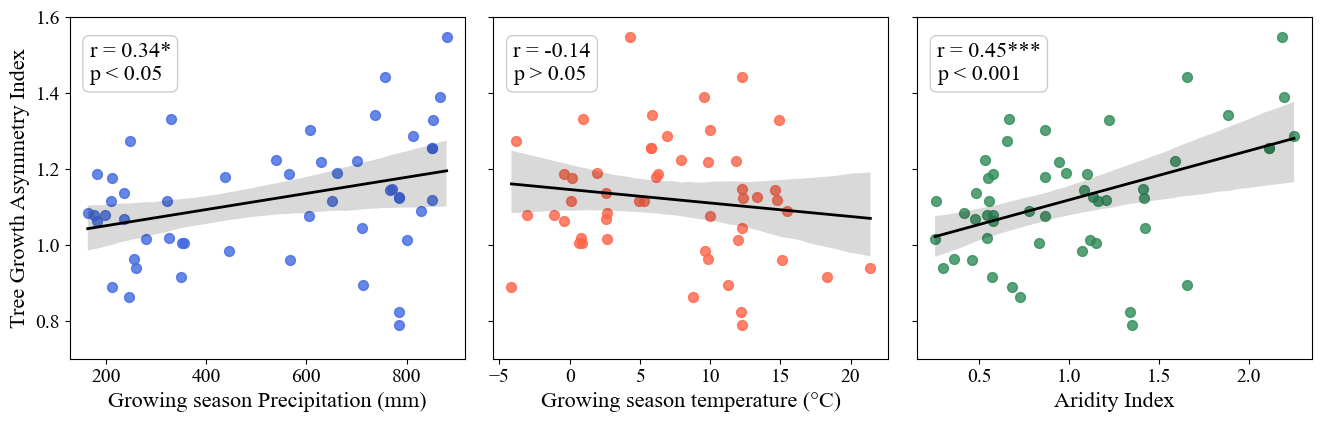

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# 
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


variables = [
    ('Pre_GS', 'Growing season Precipitation (mm)', 'royalblue'),
    ('Tmp_GS', 'Growing season temperature (°C)', 'tomato'),
    ('ai_v3', 'Aridity Index', 'seagreen')
]


y_limits = (0.7, 1.6)
y_ticks = [0.8, 1.0, 1.2, 1.4, 1.6]

fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5), sharey=True)

for ax, (var, xlabel, color) in zip(axes, variables):
    x = df_meanC[var]
    y = df_meanC['Mean']

 
    slope, intercept, r_value, p_value, std_err = linregress(x, y)


    if p_value < 0.001:
        signif = '***'
        p_label = 'p < 0.001'
    elif p_value < 0.01:
        signif = '**'
        p_label = 'p < 0.01'
    elif p_value < 0.05:
        signif = '*'
        p_label = 'p < 0.05'
    else:
        signif = ''
        p_label = 'p > 0.05'


    r_text = f"r = {r_value:.2f}{signif}\n{p_label}"


    sns.regplot(
        x=x, y=y, ax=ax,
        scatter_kws={'alpha': 0.8, 'color': color, 's': 50},
        line_kws={'color': 'black', 'lw': 2},
        ci=95
    )

    ax.set_xlabel(xlabel)
    ax.set_ylim(*y_limits)
    ax.set_yticks(y_ticks)
    
    if ax == axes[0]:
        ax.set_ylabel('Tree Growth Asymmetry Index')
    else:
        ax.set_ylabel('')


    ax.text(
        0.05, 0.80, r_text,
        transform=ax.transAxes,
        verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.4)
    )

plt.tight_layout()
# plt.savefig(r'../Rawdata/Fig1-C(3-10).jpg', dpi=600, bbox_inches='tight')
plt.show()


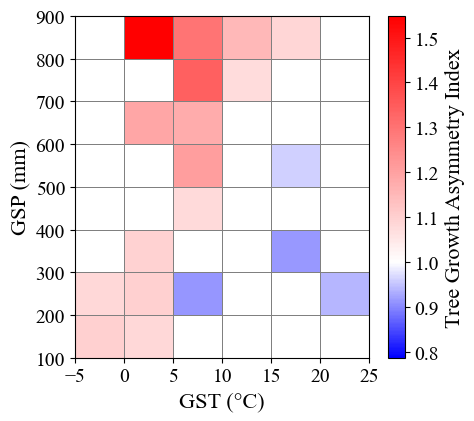

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


temp_bins = np.arange(-5, 30, 5)     
prec_bins = np.arange(100, 1000, 100) 


df_meanC['temp_bin'] = pd.cut(df_meanC['Tmp_GS'], bins=temp_bins, include_lowest=True, right=False)
df_meanC['prec_bin'] = pd.cut(df_meanC['Pre_GS'], bins=prec_bins, include_lowest=True, right=False)


pivot_table = df_meanC.pivot_table(values='Mean', index='prec_bin', columns='temp_bin', aggfunc='mean')


temp_index = pd.IntervalIndex.from_breaks(temp_bins, closed='left')
prec_index = pd.IntervalIndex.from_breaks(prec_bins, closed='left')
pivot_table = pivot_table.reindex(index=prec_index, columns=temp_index)


z = pivot_table.to_numpy()

x_edges = temp_bins
y_edges = prec_bins

assert z.shape == (len(y_edges) - 1, len(x_edges) - 1)

fig, ax = plt.subplots(figsize=(5, 4.5))

norm = mcolors.TwoSlopeNorm(vmin=df_meanC['Mean'].min(), vcenter=1.0, vmax=df_meanC['Mean'].max())
cmap = plt.get_cmap('bwr')

mesh = ax.pcolormesh(x_edges, y_edges, z,
                     cmap=cmap, norm=norm,
                     edgecolors='gray', linewidth=0.5)


ax.set_xticks(temp_bins)
ax.set_yticks(prec_bins)

ax.set_xlabel("GST (°C)", fontsize=16)
ax.set_ylabel("GSP (mm)", fontsize=16)
ax.tick_params(labelsize=14)


cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label("Tree Growth Asymmetry Index", fontsize=16)

plt.tight_layout()
# plt.savefig(r'../Rawdata/Fig/Fig1-B.jpg', dpi=600, bbox_inches='tight')
plt.show()


C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\3530642595.py:56: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


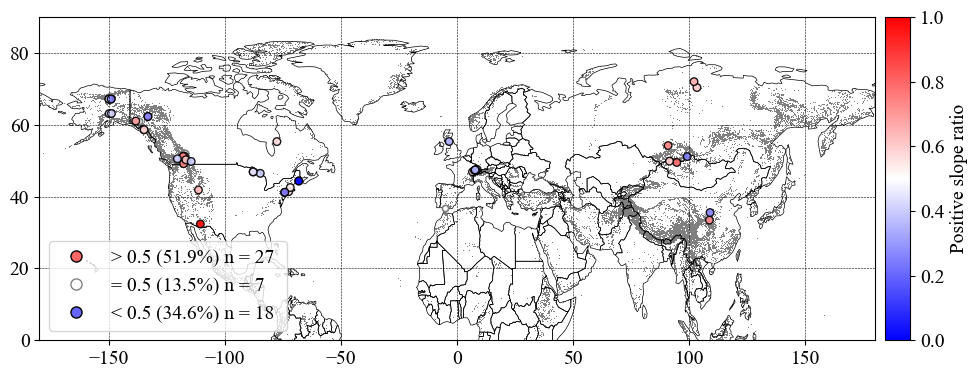

In [9]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import numpy as np
from matplotlib.lines import Line2D
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap


plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

tif_path = r"../Rawdat/GMBA_2021_MntnMask_EarthEnv_30s1Bit.tif"

with rasterio.open(tif_path) as src:
    mountain_mask = src.read(1)
    transform = src.transform
    bounds = src.bounds

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]


mountain_cmap = ListedColormap(['white', 'gray'])


geometry = [Point(xy) for xy in zip(dfslope_3_N_P['Longitude'], dfslope_3_N_P['Latitude'])]
gdf = gpd.GeoDataFrame(dfslope_3_N_P, geometry=geometry, crs='EPSG:4326')


conditions = [
    gdf['Slope_P'] > 0.5,
    gdf['Slope_P'] < 0.5,
    gdf['Slope_P'] == 0.5
]
choices = ['> 0.5', '< 0.5', '= 0.5']
gdf['mean_class'] = np.select(conditions, choices, default='= 0.5')


gdf_gt = gdf[gdf['mean_class'] == '> 0.5']
gdf_lt = gdf[gdf['mean_class'] == '< 0.5']
gdf_eq = gdf[gdf['mean_class'] == '= 0.5']


total = len(gdf)
p_gt = f"({len(gdf_gt)/total*100:.1f}%) n = {len(gdf_gt)} "
p_lt = f"({len(gdf_lt)/total*100:.1f}%) n = {len(gdf_lt)}"
p_eq = f"({len(gdf_eq)/total*100:.1f}%) n = {len(gdf_eq)}"


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


vmin = gdf['Slope_P'].min()
vcenter = 0.5
vmax = gdf['Slope_P'].max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = cm.bwr


fig, ax = plt.subplots(figsize=(10, 4))


ax.imshow(mountain_mask, cmap=mountain_cmap, extent=extent, interpolation='none')


world.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)


if not gdf_eq.empty:
    gdf_eq.plot(
        ax=ax,
        facecolor='white',
        edgecolor='gray',
        linewidth=1.2,
        markersize=20,
        label='= 1 ' + p_eq
    )

if not gdf_gt.empty:
    gdf_gt.plot(
        ax=ax,
        column='Slope_P',
        cmap=cmap,
        norm=norm,
        markersize=30,
        edgecolor='k',
        alpha=0.9
    )

if not gdf_lt.empty:
    gdf_lt.plot(
        ax=ax,
        column='Slope_P',
        cmap=cmap,
        norm=norm,
        markersize=30,
        edgecolor='k',
        alpha=0.9
    )

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=cax)
cb.set_label("Positive slope ratio")


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'> 0.5 {p_gt}',
           markerfacecolor=cmap(norm(0.8)), markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'= 0.5 {p_eq}',
           markerfacecolor='white', markeredgecolor='gray', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'< 0.5 {p_lt}',
           markerfacecolor=cmap(norm(0.2)), markeredgecolor='k', markersize=8),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=14, frameon=True)


ax.set_xlim(-180, 180)
ax.set_ylim(0, 90)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
ax.set_aspect('auto')
ax.grid(True, linestyle='--', color='black', linewidth=0.4)

plt.tight_layout()
# plt.savefig(r'../Rawdat/Fig/FigS2-PSR.jpg', dpi=600, bbox_inches='tight')
plt.show()


In [10]:
import os
import pandas as pd
import numpy as np
folder = r"../Rawdat/FZS_STD"
target_sites = dfslope_3_N_P['site'].str.upper().unique()
prefix_filter = set(df_AI['Prefix'].unique())  

records = []

for site in target_sites:
    filename = site + ".rwl.csv"
    filepath = os.path.join(folder, filename)

    if not os.path.exists(filepath):
        print(f"⚠️ ：{filename}")
        continue

    try:
        df = pd.read_csv(filepath, index_col=0)
        df.index = df.index.astype(int)
        df.columns = [col.upper() for col in df.columns]
        df = df[(df.index >= 1901) & (df.index <= 2015)]
    except Exception as e:
        print(f"❌  {filename}：{e}")
        continue

    all_cols = df.columns.tolist()

    for col in all_cols:
        if col.endswith("N"):
            prefix = col[:-1]
            if prefix not in prefix_filter:
                continue  

            col_n = col
            col_s = prefix + "S"
            if col_s in all_cols:
                s_vals = df[col_s]
                n_vals = df[col_n]
                sn_ratio = s_vals / n_vals
                sn_ratio = sn_ratio.replace([np.inf, -np.inf], np.nan).dropna()

                df_ratio = pd.DataFrame({
                    "Year": sn_ratio.index,
                    "Prefix": prefix,
                    "site": site,
                    "SN_Ratio": sn_ratio.values
                })
                records.append(df_ratio)


if records:
    df_all_sn = pd.concat(records, ignore_index=True)
    print(df_all_sn.head())
else:
    print("⚠️ ")
lower_bound = df_all_sn['SN_Ratio'].quantile(0.01)  
upper_bound = df_all_sn['SN_Ratio'].quantile(0.99)  
df_filtered = df_all_sn[(df_all_sn['SN_Ratio'] >= lower_bound) & (df_all_sn['SN_Ratio'] <= upper_bound)]
dfslope_3_N_P['site'] = dfslope_3_N_P['site'].str.strip().str.lower()
df_filtered['site'] = df_filtered['site'].str.strip().str.lower()
site_to_gmba = dfslope_3_N_P.set_index('site')['GMBA'].to_dict()
df_filtered['GMBA'] = df_filtered['site'].map(site_to_gmba)


   Year  Prefix   site  SN_Ratio
0  1901  BRCL39  AK048  1.545008
1  1902  BRCL39  AK048  1.659612
2  1903  BRCL39  AK048  1.956616
3  1904  BRCL39  AK048  2.383901
4  1905  BRCL39  AK048  1.778894


C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\711707625.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfslope_3_N_P['site'] = dfslope_3_N_P['site'].str.strip().str.lower()
C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\711707625.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['site'] = df_filtered['site'].str.strip().str.lower()
C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\711707625.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [11]:
df_filtered = df_filtered.merge(
    dfslope_3_N_P[['site', 'ai_v3']],
    on='site',
    how='left'  
)
df_filtered['climate_zone'] = df_filtered['ai_v3'].apply(
    lambda x: 'arid' if x < 0.65 else 'humid'
)


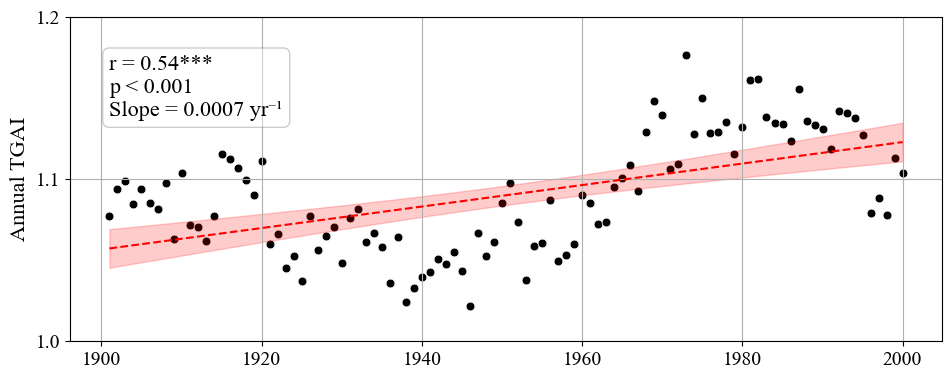

In [12]:
df_filtered_2000 = df_filtered[df_filtered['Year']<=2000]
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numpy as np
import statsmodels.api as sm


plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


df_grouped = df_filtered_2000.groupby('Year')['SN_Ratio'].mean().reset_index()
x = df_grouped['Year']
y = df_grouped['SN_Ratio']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
pred = model.get_prediction(X)
ci = pred.conf_int()
mean_pred = pred.predicted_mean


if p_value < 0.001:
    signif = '***'
    p_label = 'p < 0.001'
elif p_value < 0.01:
    signif = '**'
    p_label = 'p < 0.01'
elif p_value < 0.05:
    signif = '*'
    p_label = 'p < 0.05'
else:
    signif = ''
    p_label = 'p ≥ 0.05'


textstr = '\n'.join((
    f'r = {r_value:.2f}{signif}',
    f'{p_label}',
    f'Slope = {slope:.4f} yr⁻¹'
))


plt.figure(figsize=(10, 4))
sns.scatterplot(x=x, y=y, color='black', s=40)


plt.plot(x, mean_pred, color='red', linestyle='--', label='Linear Fit')
plt.fill_between(x, ci[:, 0], ci[:, 1], color='red', alpha=0.2, label='95% CI')


plt.text(x.min(), y.max(), textstr,
         verticalalignment='top',
         fontsize=16,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.4))


plt.xlabel("")
plt.ylabel("Annual TGAI")
plt.tight_layout()
plt.yticks([1.0, 1.1, 1.2])
# plt.ylim(0.95,1.25)
plt.grid(True)

# plt.savefig(r"../Rawdata/FigS4-A-TemporaltrendsTGAI1901-2000.jpg", dpi=600, bbox_inches='tight')
plt.show()



=== ANCOVA  ===
                  sum_sq     df          F        PR(>F)
C(Region)       0.018149    1.0  12.955251  4.040698e-04
Year            0.057774    1.0  41.239477  9.956340e-10
Year:C(Region)  0.008252    1.0   5.890667  1.612556e-02
Residual        0.274583  196.0        NaN           NaN


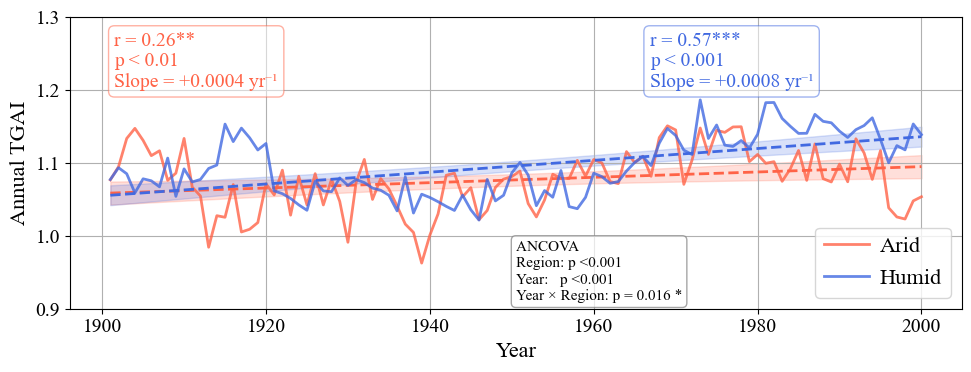

In [13]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# =========================
# Identify sites that still have observational data after 2010.

df_filtered_2000 = df_filtered[df_filtered['Year']<=2000]

df_arid = df_filtered_2000[df_filtered_2000['ai_v3'] < 0.65]
df_humid = df_filtered_2000[df_filtered_2000['ai_v3'] >= 0.65]


df_arid_grouped = df_arid.groupby('Year')['SN_Ratio'].mean().reset_index()
df_humid_grouped = df_humid.groupby('Year')['SN_Ratio'].mean().reset_index()

# =========================
plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


df_arid = df_filtered_2000[df_filtered_2000['ai_v3'] < 0.65].copy()
df_humid = df_filtered_2000[df_filtered_2000['ai_v3'] >= 0.65].copy()


df_arid_grouped = (
    df_arid.groupby('Year', as_index=False)['SN_Ratio']
           .mean()
)
df_humid_grouped = (
    df_humid.groupby('Year', as_index=False)['SN_Ratio']
            .mean()
)

df_arid_grouped['Region'] = 'Arid'
df_humid_grouped['Region'] = 'Humid'
df_all = pd.concat([df_arid_grouped, df_humid_grouped], ignore_index=True)
model = ols("SN_Ratio ~ Year * C(Region)", data=df_all).fit()
ancova_res = anova_lm(model, typ=2)

print("\n=== ANCOVA  ===")
print(ancova_res)

p_region = ancova_res.loc["C(Region)", "PR(>F)"]
p_year = ancova_res.loc["Year", "PR(>F)"]
p_inter = ancova_res.loc["Year:C(Region)", "PR(>F)"]

def signif_star(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "n.s."

ancova_text = (
    "ANCOVA \n"
    f"Region: p <0.001 \n"
    f"Year:   p <0.001\n"
    f"Year × Region: p = {p_inter:.2g} {signif_star(p_inter)}"
)

# =========================
# Plotting: Two broken lines + fitted line + regression line 95% CI
# =========================
fig, ax = plt.subplots(figsize=(10, 4))

def plot_line_with_trend(data, color, label, xpos, ax):

    data = data.sort_values('Year')
    x = data['Year'].values
    y = data['SN_Ratio'].values


    ax.plot(x, y, '-', color=color, alpha=0.8, label=label, linewidth=2)


    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    y_pred = intercept + slope * x
    ax.plot(x, y_pred, color=color, linestyle='--', linewidth=2)


    n = len(x)
    t_val = stats.t.ppf(0.975, df=n - 2)  
    s_err = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
    x_mean = np.mean(x)
    sxx = np.sum((x - x_mean) ** 2)
    conf = t_val * s_err * np.sqrt(1.0 / n + (x - x_mean) ** 2 / sxx)
    lower = y_pred - conf
    upper = y_pred + conf
    ax.fill_between(x, lower, upper, color=color, alpha=0.2)


    if p_value < 0.001:
        signif = '***'
        p_label = 'p < 0.001'
    elif p_value < 0.01:
        signif = '**'
        p_label = 'p < 0.01'
    elif p_value < 0.05:
        signif = '*'
        p_label = 'p < 0.05'
    else:
        signif = ''
        p_label = 'p ≥ 0.05'


    textstr = f"r = {r_value:.2f}{signif}\n{p_label}\nSlope = {slope:+.4f} yr⁻¹"
    ax.text(
        xpos, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top',
        color=color,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.5)
    )


plot_line_with_trend(
    df_arid_grouped[['Year', 'SN_Ratio']], 
    color='tomato', label='Arid', xpos=0.05, ax=ax
)


plot_line_with_trend(
    df_humid_grouped[['Year', 'SN_Ratio']], 
    color='royalblue', label='Humid', xpos=0.65, ax=ax
)


ax.text(
    0.5, 0.02, ancova_text,
    transform=ax.transAxes,
    fontsize=11,
    va='bottom', ha='left',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
)


ax.set_xlabel('Year')
ax.set_ylabel('Annual TGAI')
ax.legend(
    loc='lower right', frameon=True, ncol=1,
    handletextpad=0.5, columnspacing=1.0
)
ax.grid(True)
ax.set_ylim(0.9, 1.3)
ax.set_yticks([ 0.9, 1.0, 1.1, 1.2, 1.3])
plt.tight_layout()
# plt.savefig(r"../Rawdata/FigS4-B.jpg",
#             dpi=600, bbox_inches='tight')
plt.show()



=== ANCOVA ===
                  sum_sq     df          F        PR(>F)
C(Region)       0.018149    1.0  12.955251  4.040698e-04
Year            0.057774    1.0  41.239477  9.956340e-10
Year:C(Region)  0.008252    1.0   5.890667  1.612556e-02
Residual        0.274583  196.0        NaN           NaN


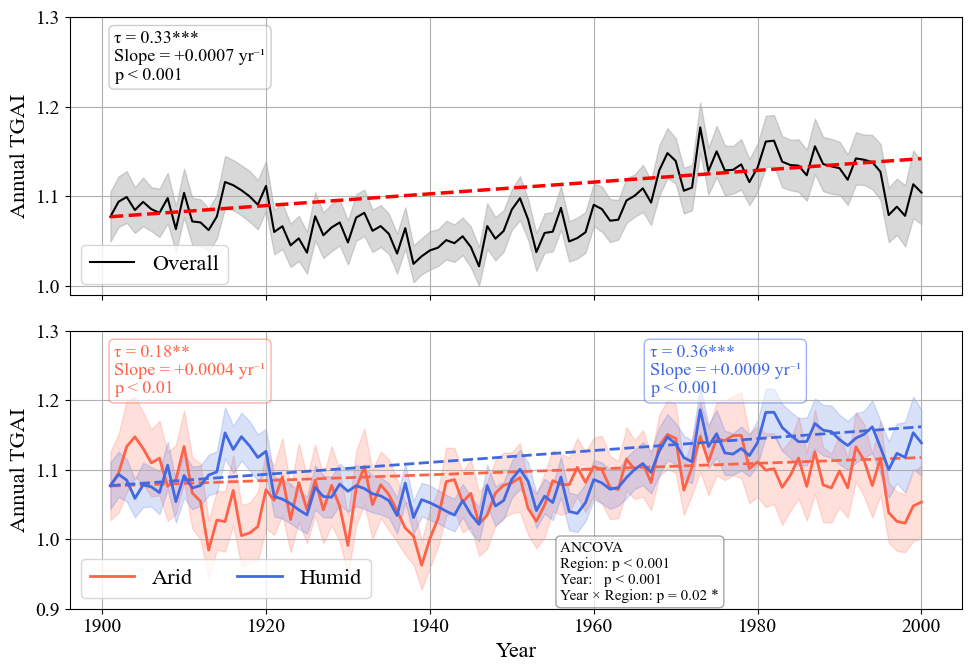

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymannkendall as mk
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

def compute_group_stats(df):
    grouped = df.groupby('Year')['SN_Ratio']
    mean_ = grouped.mean()
    std_ = grouped.std()
    n_ = grouped.count()
    df_stats = pd.DataFrame({
        'Year': mean_.index.values,
        'Mean': mean_.values,
        'Std': std_.values,
        'N': n_.values
    })
    df_stats['SE'] = df_stats['Std'] / np.sqrt(df_stats['N'])

    df_stats = df_stats.sort_values('Year').reset_index(drop=True)
    return df_stats


df_grouped_all = compute_group_stats(df_filtered_2000)
x_all = df_grouped_all['Year'].values
y_all = df_grouped_all['Mean'].values
se_all = df_grouped_all['SE'].values

mk_result_all = mk.original_test(y_all)
tau_all = mk_result_all.Tau
p_all = mk_result_all.p
slope_all = mk_result_all.slope
y_fit_all = y_all[0] + slope_all * (x_all - x_all[0])

df_arid = df_filtered_2000[df_filtered_2000['ai_v3'] < 0.65].copy()
df_humid = df_filtered_2000[df_filtered_2000['ai_v3'] >= 0.65].copy()

df_arid_grouped = compute_group_stats(df_arid)
df_humid_grouped = compute_group_stats(df_humid)


df_arid_grouped['Region'] = 'Arid'
df_humid_grouped['Region'] = 'Humid'
df_all_region = pd.concat([df_arid_grouped, df_humid_grouped], ignore_index=True)


model = ols("Mean ~ Year * C(Region)", data=df_all_region).fit()
ancova_res = anova_lm(model, typ=2)

print("\n=== ANCOVA ===")
print(ancova_res)

def signif_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

p_region = ancova_res.loc['C(Region)', 'PR(>F)']
p_year   = ancova_res.loc['Year', 'PR(>F)']
p_inter  = ancova_res.loc['Year:C(Region)', 'PR(>F)']

ancova_text = (
    "ANCOVA \n"
    f"Region: p < 0.001 \n"
    f"Year:   p < 0.001 \n"
    f"Year × Region: p = {p_inter:.1g} {signif_star(p_inter)}"
)


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 7), sharex=True)


ax1.plot(x_all, y_all, color='black', linewidth=1.5, label='Overall')
ax1.fill_between(x_all, y_all - se_all, y_all + se_all, color='gray', alpha=0.3)
ax1.plot(x_all, y_fit_all, color='red', linestyle='--', linewidth=2.5)

if p_all < 0.001:
    signif_all = '***'; p_label_all = 'p < 0.001'
elif p_all < 0.01:
    signif_all = '**'; p_label_all = 'p < 0.01'
elif p_all < 0.05:
    signif_all = '*'; p_label_all = 'p < 0.05'
else:
    signif_all = ''; p_label_all = 'p ≥ 0.05'

annotation_text_all = (
    f"τ = {tau_all:.2f}{signif_all}\n"
    f"Slope = {slope_all:+.4f} yr⁻¹\n"
    f"{p_label_all}"
)
ax1.text(
    0.05, 0.95, annotation_text_all,
    transform=ax1.transAxes, va='top',
    fontsize=13,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.4)
)
ax1.set_ylabel("Annual TGAI")
ax1.legend(loc='lower left', frameon=True)
ax1.grid(True)
ax1.set_yticks([1.0, 1.1, 1.2, 1.3])


def plot_with_mk(ax, df_stats, color, label, xpos):
    x = df_stats['Year'].values
    y = df_stats['Mean'].values
    se = df_stats['SE'].values

    ax.plot(x, y, '-', color=color, linewidth=2, label=label)
    ax.fill_between(x, y - se, y + se, color=color, alpha=0.2)

    mk_result = mk.original_test(y)
    slope = mk_result.slope
    tau = mk_result.Tau
    p = mk_result.p
    y_pred = y[0] + slope * (x - x[0])
    ax.plot(x, y_pred, color=color, linestyle='--', linewidth=2)

    if p < 0.001:
        signif = '***'; p_label = 'p < 0.001'
    elif p < 0.01:
        signif = '**'; p_label = 'p < 0.01'
    elif p < 0.05:
        signif = '*'; p_label = 'p < 0.05'
    else:
        signif = ''; p_label = 'p ≥ 0.05'

    textstr = f"τ = {tau:.2f}{signif}\nSlope = {slope:+.4f} yr⁻¹\n{p_label}"
    ax.text(
        xpos, 0.95, textstr, transform=ax.transAxes,
        fontsize=13, verticalalignment='top',
        color=color,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.5)
    )


plot_with_mk(ax2, df_arid_grouped,  'tomato',    'Arid',  xpos=0.05)
plot_with_mk(ax2, df_humid_grouped, 'royalblue', 'Humid', xpos=0.65)


ax2.text(
    0.55, 0.02, ancova_text,
    transform=ax2.transAxes,
    fontsize=11,
    va='bottom', ha='left',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
)

ax2.set_xlabel("Year")
ax2.set_ylabel("Annual TGAI")
ax2.legend(loc='lower left', frameon=True, ncol=2)
ax2.grid(True)
ax2.set_yticks([0.9, 1.0, 1.1, 1.2, 1.3])

plt.tight_layout()
# plt.savefig(r"../Rawdata/Fig/Fig2-AB.jpg", dpi=600, bbox_inches='tight')
plt.show()


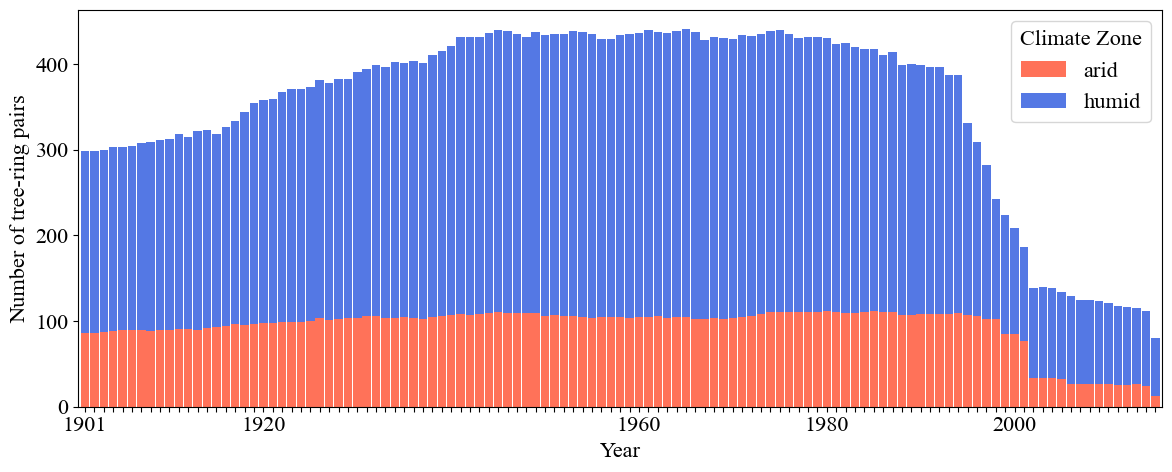

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
pivot_df = df_filtered.groupby(['Year', 'climate_zone']).size().unstack(fill_value=0)
pivot_df = pivot_df.sort_index()

custom_colors = ['tomato','royalblue']  


xtick_years = [1901, 1920, 1960, 1980, 2000]


ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    width = 0.9,
    alpha=0.9,
    figsize=(12, 5),
    color=custom_colors[:len(pivot_df.columns)]  
)


ax.set_xlabel('Year')
ax.set_ylabel('Number of tree-ring pairs')
ax.set_xticks(range(len(pivot_df.index)))
new_labels = [str(year) if year in xtick_years else '' for year in pivot_df.index]
ax.set_xticklabels(new_labels, rotation=0)
plt.legend(title='Climate Zone')
plt.tight_layout()
# plt.savefig(r"../Rawdata/Fig/FigS1-tree-ring pairs.jpg", dpi=600, bbox_inches='tight')
plt.show()



=== ANCOVA ===
                  sum_sq     df           F        PR(>F)
C(Region)       0.876668    1.0  162.487100  2.117246e-28
Year            0.071493    1.0   13.250879  3.377248e-04
Year:C(Region)  0.020644    1.0    3.826359  5.168441e-02
Residual        1.219340  226.0         NaN           NaN


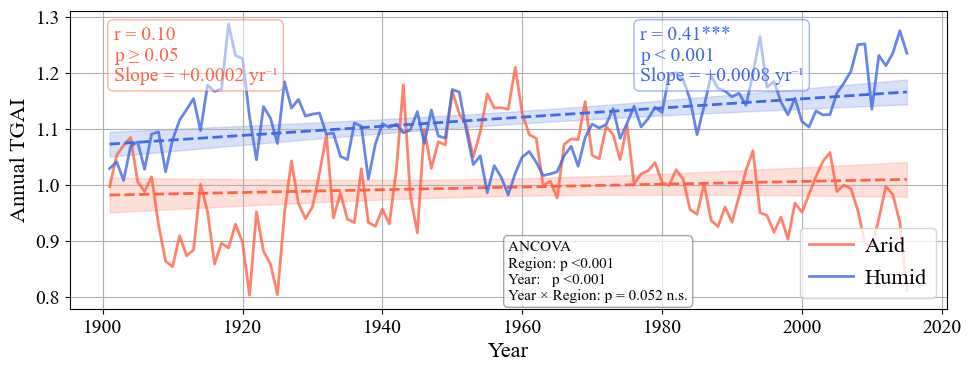

In [16]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# =========================
# Identify sites that still have observational data after 2010.
sites_after2010 = df_filtered.loc[df_filtered['Year'] > 2010, 'site'].unique()
df_sites_after2010 = df_filtered[df_filtered['site'].isin(sites_after2010)]
# =========================
plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


df_arid = df_sites_after2010[df_sites_after2010['ai_v3'] < 0.65].copy()
df_humid = df_sites_after2010[df_sites_after2010['ai_v3'] >= 0.65].copy()


df_arid_grouped = (
    df_arid.groupby('Year', as_index=False)['SN_Ratio']
           .mean()
)
df_humid_grouped = (
    df_humid.groupby('Year', as_index=False)['SN_Ratio']
            .mean()
)

df_arid_grouped['Region'] = 'Arid'
df_humid_grouped['Region'] = 'Humid'
df_all = pd.concat([df_arid_grouped, df_humid_grouped], ignore_index=True)
model = ols("SN_Ratio ~ Year * C(Region)", data=df_all).fit()
ancova_res = anova_lm(model, typ=2)

print("\n=== ANCOVA ===")
print(ancova_res)

p_region = ancova_res.loc["C(Region)", "PR(>F)"]
p_year = ancova_res.loc["Year", "PR(>F)"]
p_inter = ancova_res.loc["Year:C(Region)", "PR(>F)"]

def signif_star(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "n.s."

ancova_text = (
    "ANCOVA \n"
    f"Region: p <0.001 \n"
    f"Year:   p <0.001\n"
    f"Year × Region: p = {p_inter:.2g} {signif_star(p_inter)}"
)

# =========================
# Plotting: Two broken lines + fitted line + regression line 95% CI
# =========================
fig, ax = plt.subplots(figsize=(10, 4))

def plot_line_with_trend(data, color, label, xpos, ax):

    data = data.sort_values('Year')
    x = data['Year'].values
    y = data['SN_Ratio'].values


    ax.plot(x, y, '-', color=color, alpha=0.8, label=label, linewidth=2)


    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    y_pred = intercept + slope * x
    ax.plot(x, y_pred, color=color, linestyle='--', linewidth=2)


    n = len(x)
    t_val = stats.t.ppf(0.975, df=n - 2)  
    s_err = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
    x_mean = np.mean(x)
    sxx = np.sum((x - x_mean) ** 2)
    conf = t_val * s_err * np.sqrt(1.0 / n + (x - x_mean) ** 2 / sxx)
    lower = y_pred - conf
    upper = y_pred + conf
    ax.fill_between(x, lower, upper, color=color, alpha=0.2)


    if p_value < 0.001:
        signif = '***'
        p_label = 'p < 0.001'
    elif p_value < 0.01:
        signif = '**'
        p_label = 'p < 0.01'
    elif p_value < 0.05:
        signif = '*'
        p_label = 'p < 0.05'
    else:
        signif = ''
        p_label = 'p ≥ 0.05'


    textstr = f"r = {r_value:.2f}{signif}\n{p_label}\nSlope = {slope:+.4f} yr⁻¹"
    ax.text(
        xpos, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top',
        color=color,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.5)
    )


plot_line_with_trend(
    df_arid_grouped[['Year', 'SN_Ratio']], 
    color='tomato', label='Arid', xpos=0.05, ax=ax
)


plot_line_with_trend(
    df_humid_grouped[['Year', 'SN_Ratio']], 
    color='royalblue', label='Humid', xpos=0.65, ax=ax
)


ax.text(
    0.5, 0.02, ancova_text,
    transform=ax.transAxes,
    fontsize=11,
    va='bottom', ha='left',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
)


ax.set_xlabel('Year')
ax.set_ylabel('Annual TGAI')
ax.legend(
    loc='lower right', frameon=True, ncol=1,
    handletextpad=0.5, columnspacing=1.0
)
ax.grid(True)

plt.tight_layout()
# plt.savefig(r"../Rawdata/Fig/FigS6-B-27ste-climate.jpg",
#             dpi=600, bbox_inches='tight')
plt.show()


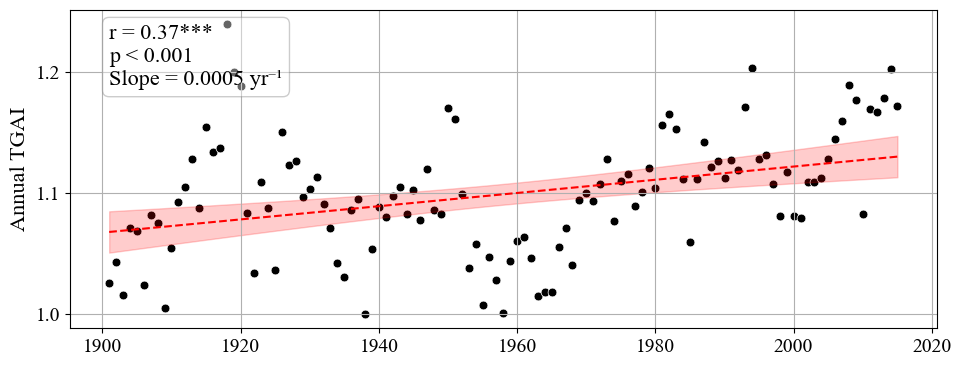

In [17]:

df_grouped = df_sites_after2010.groupby('Year')['SN_Ratio'].mean().reset_index()
x = df_grouped['Year']
y = df_grouped['SN_Ratio']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
pred = model.get_prediction(X)
ci = pred.conf_int()
mean_pred = pred.predicted_mean


if p_value < 0.001:
    signif = '***'
    p_label = 'p < 0.001'
elif p_value < 0.01:
    signif = '**'
    p_label = 'p < 0.01'
elif p_value < 0.05:
    signif = '*'
    p_label = 'p < 0.05'
else:
    signif = ''
    p_label = 'p ≥ 0.05'


textstr = '\n'.join((
    f'r = {r_value:.2f}{signif}',
    f'{p_label}',
    f'Slope = {slope:.4f} yr⁻¹'
))


plt.figure(figsize=(10, 4))
sns.scatterplot(x=x, y=y, color='black', s=40)


plt.plot(x, mean_pred, color='red', linestyle='--', label='Linear Fit')
plt.fill_between(x, ci[:, 0], ci[:, 1], color='red', alpha=0.2, label='95% CI')


plt.text(x.min(), y.max(), textstr,
         verticalalignment='top',
         fontsize=16,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.4))


plt.xlabel("")
plt.ylabel("Annual TGAI")
plt.tight_layout()
plt.yticks([1.0, 1.1, 1.2])
# plt.ylim(0.95,1.25)
plt.grid(True)

# plt.savefig(r"../Rawdata/Fig/FigS6-A-TemporaltrendsTGAI1901-2015-27site.jpg", dpi=600, bbox_inches='tight')
plt.show()


In [18]:
# === Step-by-step  ===
grouped_summary_3_slope = (
    df_AI.groupby('Filename')  
    .filter(lambda df: len(df) >= 4)  
    .groupby('Filename')  
    .agg(
        Slope_P=('Slope', lambda x: (x > 0).mean()),  
        Slope_Mean=('Slope', 'mean'),
        start_year = ('Start_year','mean') ,
        end_year =('End_year','mean')          
    )
    .reset_index()  
)
grouped_summary_3_slope['site'] = grouped_summary_3_slope['Filename'].str.replace('.rwl.csv', '', regex=False)

In [19]:
dfm_slope = pd.merge(dfslope_3_N_P.loc[:,'site':],grouped_summary_3_slope)

C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\2343544683.py:56: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


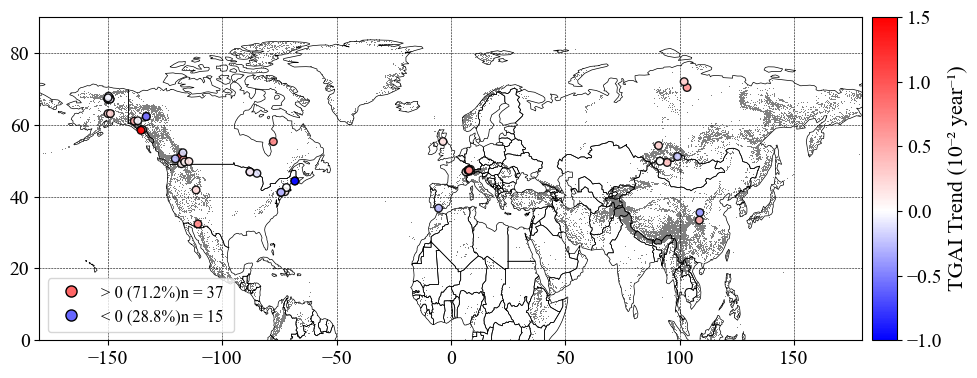

In [20]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import numpy as np
from matplotlib.lines import Line2D
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap


plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


tif_path = r"../Rawdat/GMBA_2021_MntnMask_EarthEnv_30s1Bit.tif"

with rasterio.open(tif_path) as src:
    mountain_mask = src.read(1)
    transform = src.transform
    bounds = src.bounds
    raster_crs = src.crs  

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]


mountain_cmap = ListedColormap(['white', 'gray'])


geometry = [Point(xy) for xy in zip(dfm_slope['Longitude'], dfm_slope['Latitude'])]
gdf = gpd.GeoDataFrame(dfm_slope, geometry=geometry, crs='EPSG:4326')


if raster_crs != gdf.crs:
    gdf = gdf.to_crs(raster_crs)


conditions = [
    gdf['Slope_Mean'] > 0,
    gdf['Slope_Mean'] < 0
]
choices = ['> 0', '< 0']
gdf['mean_class'] = np.select(conditions, choices, default=np.nan)

gdf_gt = gdf[gdf['mean_class'] == '> 0']
gdf_lt = gdf[gdf['mean_class'] == '< 0']
total = len(gdf_gt) + len(gdf_lt)
p_gt = f"({len(gdf_gt)/total*100:.1f}%)n = {len(gdf_gt)} "
p_lt = f"({len(gdf_lt)/total*100:.1f}%)n = {len(gdf_lt)} "


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

vmin = gdf['Slope_Mean'].min()
vcenter = 0
vmax = gdf['Slope_Mean'].max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = cm.bwr


fig, ax = plt.subplots(figsize=(10, 4))


ax.imshow(mountain_mask, cmap=mountain_cmap, extent=extent, interpolation='none', zorder=0)


world.to_crs(gdf.crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, zorder=1)


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)


if not gdf_gt.empty:
    gdf_gt.plot(
        ax=ax, column='Slope_Mean', cmap=cmap, norm=norm,
        markersize=30, edgecolor='k', alpha=0.9, zorder=3
    )

if not gdf_lt.empty:
    gdf_lt.plot(
        ax=ax, column='Slope_Mean', cmap=cmap, norm=norm,
        markersize=30, edgecolor='k', alpha=0.9, zorder=3
    )




vmin = -1.0
vmax = 1.5
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = cm.bwr


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cb = plt.colorbar(sm, cax=cax)
cb.set_ticks([-1.0, -0.5, 0, 0.5, 1.0, 1.5])
cb.set_label("TGAI Trend (10⁻² year⁻¹)", fontsize=16)
cb.ax.tick_params(labelsize=14)



legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'> 0 {p_gt}',
           markerfacecolor=cmap(norm(vmax*0.6)), markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'< 0 {p_lt}',
           markerfacecolor=cmap(norm(vmin*0.6)), markeredgecolor='k', markersize=8),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=12, frameon=True)


ax.set_xlim(-180, 180)
ax.set_ylim(0, 90)
ax.set_aspect('auto')
ax.grid(True, linestyle='--', color='black', linewidth=0.4)

plt.tight_layout()
# plt.savefig(r'../Rawdata/Fig/Fig2-A.jpg', dpi=600, bbox_inches='tight')
plt.show()


In [22]:

gdf['climate_zone'] = np.where(gdf['ai_v3'] < 0.65, 'Arid', 'Humid')


def calc_positive_slope_ratio(group):
    total = len(group)
    positive = (group['Slope_Mean'] > 0).sum()
    return round(positive / total, 3) if total > 0 else np.nan


slope_ratio = gdf.groupby('climate_zone').apply(calc_positive_slope_ratio).rename('Positive_Slope_Ratio')



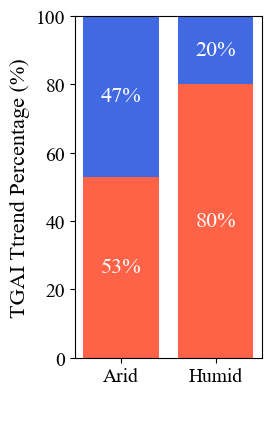

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

gdf['Trend'] = gdf['Slope_Mean'].apply(lambda x: 'Increasing' if x > 0 else 'Decreasing')


df_percent = (
    gdf.groupby(['climate_zone', 'Trend'])
       .size()
       .reset_index(name='Count')
       .pivot(index='climate_zone', columns='Trend', values='Count')
       .fillna(0)
)

df_percent['Total'] = df_percent.sum(axis=1)
df_percent['Increasing_%'] = df_percent['Increasing'] / df_percent['Total'] * 100
df_percent['Decreasing_%'] = df_percent['Decreasing'] / df_percent['Total'] * 100


fig, ax = plt.subplots(figsize=(3, 4.5))
climate_zones = df_percent.index.tolist()
increasing = df_percent['Increasing_%'].values
decreasing = df_percent['Decreasing_%'].values

ax.bar(climate_zones, increasing, label='Increasing', color='tomato')
ax.bar(climate_zones, decreasing, bottom=increasing, label='Decreasing', color='royalblue')


ax.set_ylabel('TGAI Ttrend Percentage (%)', fontsize=16)
ax.set_xlabel(' ')
ax.set_ylim(0, 100)


for i, (inc, dec) in enumerate(zip(increasing, decreasing)):
    ax.text(i, inc / 2, f'{inc:.0f}%', ha='center', va='center', color='white', fontsize=16)
    ax.text(i, inc + dec / 2, f'{dec:.0f}%', ha='center', va='center', color='white', fontsize=16)

plt.tight_layout()
# plt.savefig(r'../Rawdata/Fig/Fig2-B.jpg', dpi=600, bbox_inches='tight')
plt.show()


In [24]:
df_slopeT= pd.merge(dfm_slope,df_meanC.loc[:, ['site','Pre_GS','Tmp_GS']])

0.15260337293837808
0.7670131308626832
0.0044568105549752865


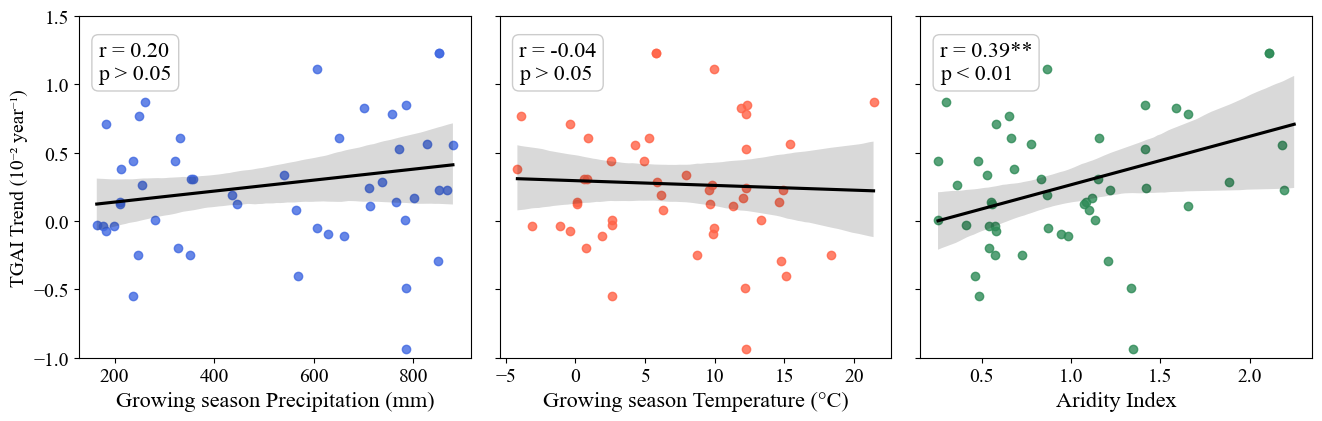

In [25]:
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import linregress


plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

df = df_slopeT.dropna()


variables = [
    ('Pre_GS', 'Growing season Precipitation (mm)', 'royalblue'),
    ('Tmp_GS', 'Growing season Temperature (°C)', 'tomato'),
    ('ai_v3', 'Aridity Index', 'seagreen')
]


y_ticks = [-1.0, -0.5, 0, 0.5, 1.0, 1.5]
y_label = "TGAI Trend (10⁻² year⁻¹)"

fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5), sharey=True)

for ax, (var, xlabel, color) in zip(axes, variables):
    

    x = df[var]
    y = df['Slope_Mean'] * 100  

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print(p_value)        

    if p_value < 0.001:
        signif = '***'
        p_label = 'p < 0.001'
    elif p_value < 0.01:
        signif = '**'
        p_label = 'p < 0.01'
    elif p_value < 0.05:
        signif = '*'
        p_label = 'p < 0.05'
    else:
        signif = ''
        p_label = 'p > 0.05'
 
    
    r_text = f"r = {r_value:.2f}{signif}\n{p_label}"


    sns.regplot(x=x, y=y, ax=ax,
                scatter_kws={'alpha': 0.8, 'color': color},
                line_kws={'color': 'black'}, ci=95)

    ax.set_xlabel(xlabel)
    ax.set_yticks(y_ticks)
    ax.set_ylim(min(y_ticks), max(y_ticks))

    if ax == axes[0]:
        ax.set_ylabel(y_label, fontsize=14)
    else:
        ax.set_ylabel('')


    ax.text(
        0.05, 0.80, r_text,
        transform=ax.transAxes,
        verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.4)
    )

plt.tight_layout()
# plt.savefig(r'../Rawdata/Fig/Fig3-CDE.jpg', dpi=600, bbox_inches='tight')
plt.show()


In [26]:
###5
# === Step-by-step  ===
grouped_summary_3 = (
    df_AI.groupby('Filename')  
    .filter(lambda df: len(df) >= 5)  
    .groupby('Filename') 
    .agg(
        Slope_P=('Slope', lambda x: (x > 0).mean()), 
        Mean=('Mean', 'mean')                 
    )
    .reset_index()  
)

In [ ]:
df_siteg = gpd.read_file("../Rawdat/ITRDB_site.shp")
grouped_summary_3['site'] = grouped_summary_3['Filename'].str.replace('.rwl.csv', '', regex=False)
dfslope_3 = pd.merge(grouped_summary_3.loc[:,'Slope_P':],df_siteg.loc[:,['Latitude', 'Longitude', 'DEM','site','ai_v3','GMBA','Tree_Speci']])


In [28]:
dfslope_3_N_P = dfslope_3[(dfslope_3['Latitude']>0)]
df_AI['site'] = df_AI['site'].str.lower()
dfslope_3_N_P['site'] = dfslope_3_N_P['site'].str.lower()
sites_of_interest = dfslope_3_N_P['site'].unique()
filtered_sig_df = df_AI[df_AI['site'].isin(sites_of_interest)]
summary_df = filtered_sig_df.groupby('site').agg({
    'Start_year': 'min',
    'End_year': 'max',
    'Mean': 'mean',
    'Prefix': pd.Series.nunique
}).reset_index()
summary_df = pd.merge(dfslope_3_N_P[['site']], summary_df, on='site', how='left')
df_site_allsite =pd.read_csv(r"../Rawdat/itrdb_dem_landconr_values.csv")
dfsite52itrdb = pd.merge(summary_df,df_site_allsite.loc[:,'Latitude':],on='site')
# dfsite52itrdb.to_csv(r'../Rawdat/sitede.csv')

C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\2476999294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfslope_3_N_P['site'] = dfslope_3_N_P['site'].str.lower()


C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\3171179259.py:50: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


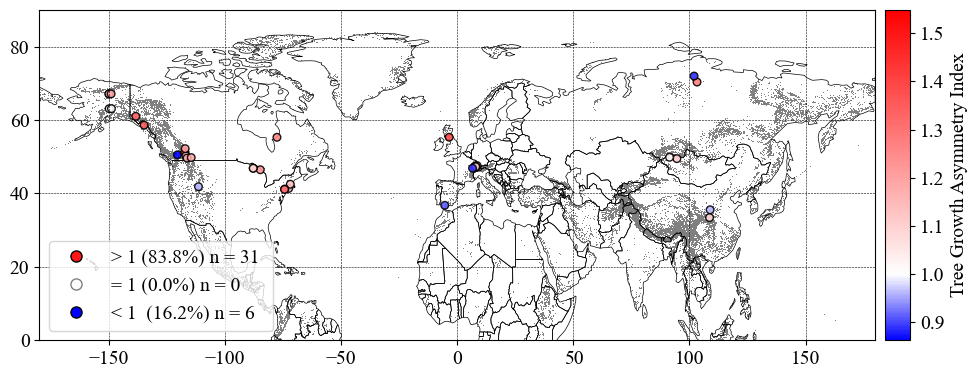

In [29]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import numpy as np
from matplotlib.lines import Line2D
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap


plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

tif_path = r"../Rawdat/GMBA_2021_MntnMask_EarthEnv_30s1Bit.tif"

with rasterio.open(tif_path) as src:
    mountain_mask = src.read(1)
    transform = src.transform
    bounds = src.bounds

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

mountain_cmap = ListedColormap(['white', 'gray'])

geometry = [Point(xy) for xy in zip(dfslope_3_N_P['Longitude'], dfslope_3_N_P['Latitude'])]
gdf = gpd.GeoDataFrame(dfslope_3_N_P, geometry=geometry, crs='EPSG:4326')

conditions = [
    gdf['Mean'] > 1,
    gdf['Mean'] < 1,
    gdf['Mean'] == 1
]
choices = ['> 1', '< 1', '= 1']
gdf['mean_class'] = np.select(conditions, choices, default='= 1')

gdf_gt = gdf[gdf['mean_class'] == '> 1']
gdf_lt = gdf[gdf['mean_class'] == '< 1']
gdf_eq = gdf[gdf['mean_class'] == '= 1']

total = len(gdf)
p_gt = f"({len(gdf_gt)/total*100:.1f}%) n = {len(gdf_gt)} "
p_lt = f" ({len(gdf_lt)/total*100:.1f}%) n = {len(gdf_lt)}"
p_eq = f"({len(gdf_eq)/total*100:.1f}%) n = {len(gdf_eq)}"

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

vmin = gdf['Mean'].min()
vcenter = 1
vmax = gdf['Mean'].max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = cm.bwr

fig, ax = plt.subplots(figsize=(10, 4))

ax.imshow(mountain_mask, cmap=mountain_cmap, extent=extent, interpolation='none')

world.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)


if not gdf_eq.empty:
    gdf_eq.plot(
        ax=ax,
        facecolor='white',
        edgecolor='gray',
        linewidth=1.2,
        markersize=20,
        label='= 1 ' + p_eq
    )

if not gdf_gt.empty:
    gdf_gt.plot(
        ax=ax,
        column='Mean',
        cmap=cmap,
        norm=norm,
        markersize=30,
        edgecolor='k',
        alpha=0.9
    )

if not gdf_lt.empty:
    gdf_lt.plot(
        ax=ax,
        column='Mean',
        cmap=cmap,
        norm=norm,
        markersize=30,
        edgecolor='k',
        alpha=0.9
    )


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=cax)
cb.set_label("Tree Growth Asymmetry Index")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'> 1 {p_gt}',
           markerfacecolor=cmap(norm(1.5)), markeredgecolor='k', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'= 1 {p_eq}',
           markerfacecolor='white', markeredgecolor='gray', markersize=8),
    Line2D([0], [0], marker='o', color='w', label=f'< 1 {p_lt}',
           markerfacecolor=cmap(norm(0.8)), markeredgecolor='k', markersize=8),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=14, frameon=True)
ax.set_xlim(-180, 180)
ax.set_ylim(0, 90)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
ax.set_aspect('auto')
ax.grid(True, linestyle='--', color='black', linewidth=0.4)

plt.tight_layout()
# plt.savefig(r'../Rawdata/Fig/FigS7-A.jpg', dpi=600, bbox_inches='tight')
plt.show()


In [30]:
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np


if not hasattr(np, "alen"):
    np.alen = lambda a: len(a)
# === paths ===
pre_path = r"../Rawdat/cru_ts4.07.1901.2022.pre.dat.nc"
tmp_path = r"../Rawdat/cru_ts4.07.1901.2022.tmp.dat.nc"

gdf = gdf.copy()
if 'Longitude' not in gdf.columns or 'Latitude' not in gdf.columns:
    gdf['Longitude'] = gdf.geometry.x
    gdf['Latitude'] = gdf.geometry.y

ds_pre = xr.open_dataset(pre_path)
ds_tmp = xr.open_dataset(tmp_path)
gs_months = np.arange(3, 11)
pre = ds_pre['pre']  # mm/month
pre_gs = pre.where(pre['time'].dt.month.isin(gs_months), drop=True)
pre_gs_annual = pre_gs.groupby('time.year').sum(dim='time')
pre_gs_clim = pre_gs_annual.mean(dim='year')
tmp = ds_tmp['tmp']  # °C
tmp_gs = tmp.where(tmp['time'].dt.month.isin(gs_months), drop=True)
tmp_gs_annual = tmp_gs.groupby('time.year').mean(dim='time')
tmp_gs_clim = tmp_gs_annual.mean(dim='year')
lon_points = xr.DataArray(gdf['Longitude'].values, dims=('points',))
lat_points = xr.DataArray(gdf['Latitude'].values, dims=('points',))
pre_gs_vals = pre_gs_clim.interp(lon=lon_points, lat=lat_points, method='linear').values
tmp_gs_vals = tmp_gs_clim.interp(lon=lon_points, lat=lat_points, method='linear').values
gdf['Pre_GS'] = pre_gs_vals       
gdf['Tmp_GS'] = tmp_gs_vals        
print(gdf[['Longitude', 'Latitude', 'Pre_GS', 'Tmp_GS']].head())
df_meanC = gdf.dropna(subset=['Pre_GS', 'Tmp_GS', 'Mean']).copy()

   Longitude  Latitude      Pre_GS    Tmp_GS
0    -150.08     67.12  211.269044  0.148886
1    -150.08     67.15  210.686734  0.120982
2    -149.13     67.15  182.840835 -0.408542
3    -150.00     63.10  356.425247  0.638171
4    -149.00     63.12  352.407955  0.839423


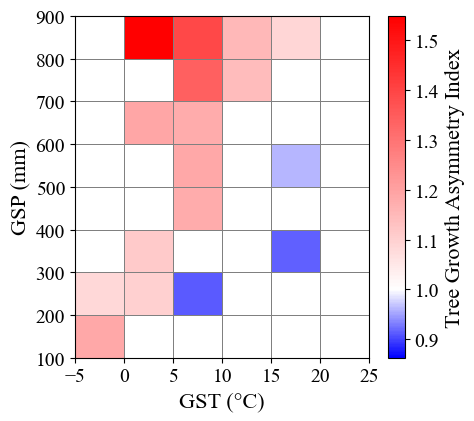

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


temp_bins = np.arange(-5, 30, 5)     
prec_bins = np.arange(100, 1000, 100) 


df_meanC['temp_bin'] = pd.cut(df_meanC['Tmp_GS'], bins=temp_bins, include_lowest=True, right=False)
df_meanC['prec_bin'] = pd.cut(df_meanC['Pre_GS'], bins=prec_bins, include_lowest=True, right=False)


pivot_table = df_meanC.pivot_table(values='Mean', index='prec_bin', columns='temp_bin', aggfunc='mean')


temp_index = pd.IntervalIndex.from_breaks(temp_bins, closed='left')
prec_index = pd.IntervalIndex.from_breaks(prec_bins, closed='left')
pivot_table = pivot_table.reindex(index=prec_index, columns=temp_index)


z = pivot_table.to_numpy()

x_edges = temp_bins
y_edges = prec_bins

assert z.shape == (len(y_edges) - 1, len(x_edges) - 1)

fig, ax = plt.subplots(figsize=(5, 4.5))

norm = mcolors.TwoSlopeNorm(vmin=df_meanC['Mean'].min(), vcenter=1.0, vmax=df_meanC['Mean'].max())
cmap = plt.get_cmap('bwr')

mesh = ax.pcolormesh(x_edges, y_edges, z,
                     cmap=cmap, norm=norm,
                     edgecolors='gray', linewidth=0.5)


ax.set_xticks(temp_bins)
ax.set_yticks(prec_bins)

ax.set_xlabel("GST (°C)", fontsize=16)
ax.set_ylabel("GSP (mm)", fontsize=16)
ax.tick_params(labelsize=14)


cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label("Tree Growth Asymmetry Index", fontsize=16)

plt.tight_layout()
# plt.savefig(r'../Rawdata/Fig/FigS6-B.jpg', dpi=600, bbox_inches='tight')
plt.show()


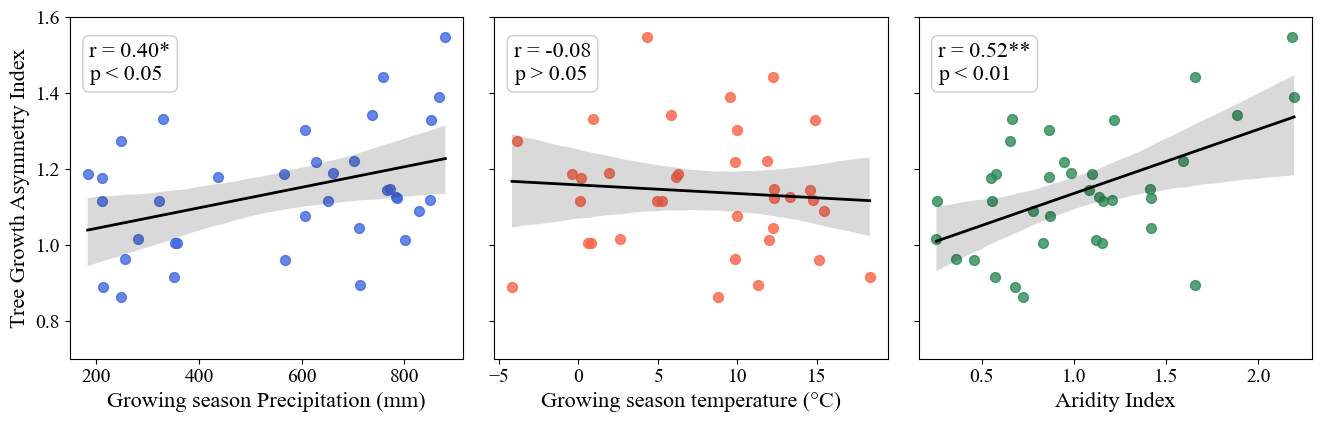

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

variables = [
    ('Pre_GS', 'Growing season Precipitation (mm)', 'royalblue'),
    ('Tmp_GS', 'Growing season temperature (°C)', 'tomato'),
    ('ai_v3', 'Aridity Index', 'seagreen')
]

y_limits = (0.7, 1.6)
y_ticks = [0.8, 1.0, 1.2, 1.4, 1.6]

fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5), sharey=True)

for ax, (var, xlabel, color) in zip(axes, variables):
    x = df_meanC[var]
    y = df_meanC['Mean']

 
    slope, intercept, r_value, p_value, std_err = linregress(x, y)


    if p_value < 0.001:
        signif = '***'
        p_label = 'p < 0.001'
    elif p_value < 0.01:
        signif = '**'
        p_label = 'p < 0.01'
    elif p_value < 0.05:
        signif = '*'
        p_label = 'p < 0.05'
    else:
        signif = ''
        p_label = 'p > 0.05'


    r_text = f"r = {r_value:.2f}{signif}\n{p_label}"


    sns.regplot(
        x=x, y=y, ax=ax,
        scatter_kws={'alpha': 0.8, 'color': color, 's': 50},
        line_kws={'color': 'black', 'lw': 2},
        ci=95
    )

    ax.set_xlabel(xlabel)
    ax.set_ylim(*y_limits)
    ax.set_yticks(y_ticks)
    
    if ax == axes[0]:
        ax.set_ylabel('Tree Growth Asymmetry Index')
    else:
        ax.set_ylabel('')


    ax.text(
        0.05, 0.80, r_text,
        transform=ax.transAxes,
        verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.4)
    )

plt.tight_layout()
# plt.savefig(r'../Rawdata/Fig/FigS6C.jpg', dpi=600, bbox_inches='tight')
plt.show()


In [33]:
import os
import pandas as pd
import numpy as np
folder = r"../Rawdat/FZS_STD"
target_sites = dfslope_3_N_P['site'].str.upper().unique()
prefix_filter = set(df_AI['Prefix'].unique())  

records = []

for site in target_sites:
    filename = site + ".rwl.csv"
    filepath = os.path.join(folder, filename)

    if not os.path.exists(filepath):
        print(f"⚠️ ：{filename}")
        continue

    try:
        df = pd.read_csv(filepath, index_col=0)
        df.index = df.index.astype(int)
        df.columns = [col.upper() for col in df.columns]
        df = df[(df.index >= 1901) & (df.index <= 2015)]
    except Exception as e:
        print(f"❌  {filename}：{e}")
        continue

    all_cols = df.columns.tolist()

    for col in all_cols:
        if col.endswith("N"):
            prefix = col[:-1]
            if prefix not in prefix_filter:
                continue  

            col_n = col
            col_s = prefix + "S"
            if col_s in all_cols:
                s_vals = df[col_s]
                n_vals = df[col_n]
                sn_ratio = s_vals / n_vals
                sn_ratio = sn_ratio.replace([np.inf, -np.inf], np.nan).dropna()

                df_ratio = pd.DataFrame({
                    "Year": sn_ratio.index,
                    "Prefix": prefix,
                    "site": site,
                    "SN_Ratio": sn_ratio.values
                })
                records.append(df_ratio)


if records:
    df_all_sn = pd.concat(records, ignore_index=True)
    print(df_all_sn.head())
else:
    print("⚠️ ")
lower_bound = df_all_sn['SN_Ratio'].quantile(0.01)  
upper_bound = df_all_sn['SN_Ratio'].quantile(0.99)  
df_filtered = df_all_sn[(df_all_sn['SN_Ratio'] >= lower_bound) & (df_all_sn['SN_Ratio'] <= upper_bound)]
dfslope_3_N_P['site'] = dfslope_3_N_P['site'].str.strip().str.lower()
df_filtered['site'] = df_filtered['site'].str.strip().str.lower()
site_to_gmba = dfslope_3_N_P.set_index('site')['GMBA'].to_dict()
df_filtered['GMBA'] = df_filtered['site'].map(site_to_gmba)


   Year  Prefix   site  SN_Ratio
0  1901  BRCL39  AK048  1.545008
1  1902  BRCL39  AK048  1.659612
2  1903  BRCL39  AK048  1.956616
3  1904  BRCL39  AK048  2.383901
4  1905  BRCL39  AK048  1.778894


C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\711707625.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfslope_3_N_P['site'] = dfslope_3_N_P['site'].str.strip().str.lower()
C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\711707625.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['site'] = df_filtered['site'].str.strip().str.lower()
C:\Users\MSI\AppData\Local\Temp\ipykernel_4744\711707625.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [34]:
df_filtered = df_filtered.merge(
    dfslope_3_N_P[['site', 'ai_v3']],
    on='site',
    how='left'  
)
df_filtered['climate_zone'] = df_filtered['ai_v3'].apply(
    lambda x: 'arid' if x < 0.65 else 'humid'
)


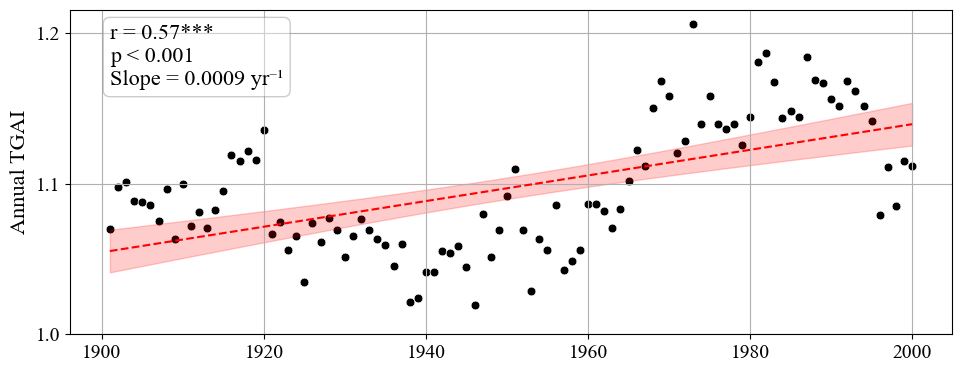

In [35]:
df_filtered_cs = df_filtered[df_filtered['Year']<=2000]
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numpy as np
import statsmodels.api as sm


plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


df_grouped = df_filtered_cs.groupby('Year')['SN_Ratio'].mean().reset_index()
x = df_grouped['Year']
y = df_grouped['SN_Ratio']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
pred = model.get_prediction(X)
ci = pred.conf_int()
mean_pred = pred.predicted_mean


if p_value < 0.001:
    signif = '***'
    p_label = 'p < 0.001'
elif p_value < 0.01:
    signif = '**'
    p_label = 'p < 0.01'
elif p_value < 0.05:
    signif = '*'
    p_label = 'p < 0.05'
else:
    signif = ''
    p_label = 'p ≥ 0.05'


textstr = '\n'.join((
    f'r = {r_value:.2f}{signif}',
    f'{p_label}',
    f'Slope = {slope:.4f} yr⁻¹'
))


plt.figure(figsize=(10, 4))
sns.scatterplot(x=x, y=y, color='black', s=40)


plt.plot(x, mean_pred, color='red', linestyle='--', label='Linear Fit')
plt.fill_between(x, ci[:, 0], ci[:, 1], color='red', alpha=0.2, label='95% CI')


plt.text(x.min(), y.max(), textstr,
         verticalalignment='top',
         fontsize=16,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.4))


plt.xlabel("")
plt.ylabel("Annual TGAI")
plt.tight_layout()
plt.yticks([1.0, 1.1, 1.2])
# plt.ylim(0.95,1.25)
plt.grid(True)

# plt.savefig(r"../Rawdata/Fig/FigS8-A-TemporaltrendsTGAI1901-2000.jpg", dpi=600, bbox_inches='tight')
plt.show()



=== ANCOVA===
                  sum_sq     df          F        PR(>F)
C(Region)       0.047220    1.0  24.928063  1.311402e-06
Year            0.112209    1.0  59.236833  6.700407e-13
Year:C(Region)  0.001902    1.0   1.004094  3.175575e-01
Residual        0.371272  196.0        NaN           NaN


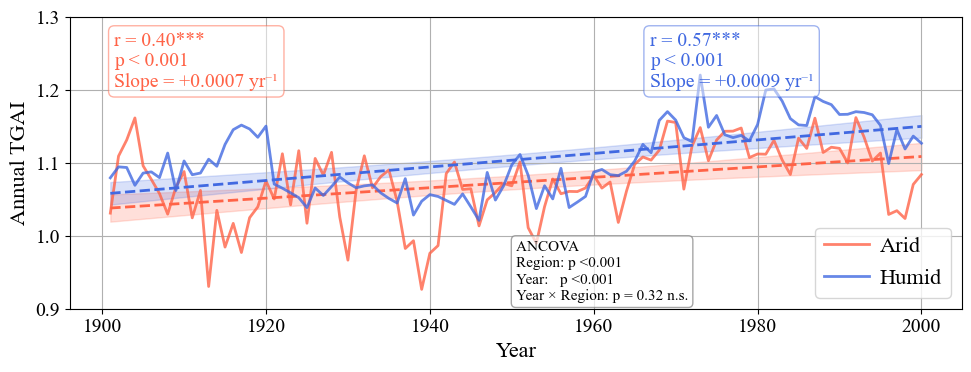

In [36]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm



df_filtered_2000 = df_filtered[df_filtered['Year']<=2000]

df_arid = df_filtered_cs[df_filtered_cs['ai_v3'] < 0.65]
df_humid = df_filtered_cs[df_filtered_cs['ai_v3'] >= 0.65]


df_arid_grouped = df_arid.groupby('Year')['SN_Ratio'].mean().reset_index()
df_humid_grouped = df_humid.groupby('Year')['SN_Ratio'].mean().reset_index()


plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14


df_arid = df_filtered_2000[df_filtered_2000['ai_v3'] < 0.65].copy()
df_humid = df_filtered_2000[df_filtered_2000['ai_v3'] >= 0.65].copy()


df_arid_grouped = (
    df_arid.groupby('Year', as_index=False)['SN_Ratio']
           .mean()
)
df_humid_grouped = (
    df_humid.groupby('Year', as_index=False)['SN_Ratio']
            .mean()
)

df_arid_grouped['Region'] = 'Arid'
df_humid_grouped['Region'] = 'Humid'
df_all = pd.concat([df_arid_grouped, df_humid_grouped], ignore_index=True)
model = ols("SN_Ratio ~ Year * C(Region)", data=df_all).fit()
ancova_res = anova_lm(model, typ=2)

print("\n=== ANCOVA===")
print(ancova_res)

p_region = ancova_res.loc["C(Region)", "PR(>F)"]
p_year = ancova_res.loc["Year", "PR(>F)"]
p_inter = ancova_res.loc["Year:C(Region)", "PR(>F)"]

def signif_star(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "n.s."

ancova_text = (
    "ANCOVA \n"
    f"Region: p <0.001 \n"
    f"Year:   p <0.001\n"
    f"Year × Region: p = {p_inter:.2g} {signif_star(p_inter)}"
)


fig, ax = plt.subplots(figsize=(10, 4))

def plot_line_with_trend(data, color, label, xpos, ax):

    data = data.sort_values('Year')
    x = data['Year'].values
    y = data['SN_Ratio'].values


    ax.plot(x, y, '-', color=color, alpha=0.8, label=label, linewidth=2)


    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    y_pred = intercept + slope * x
    ax.plot(x, y_pred, color=color, linestyle='--', linewidth=2)


    n = len(x)
    t_val = stats.t.ppf(0.975, df=n - 2)  
    s_err = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
    x_mean = np.mean(x)
    sxx = np.sum((x - x_mean) ** 2)
    conf = t_val * s_err * np.sqrt(1.0 / n + (x - x_mean) ** 2 / sxx)
    lower = y_pred - conf
    upper = y_pred + conf
    ax.fill_between(x, lower, upper, color=color, alpha=0.2)


    if p_value < 0.001:
        signif = '***'
        p_label = 'p < 0.001'
    elif p_value < 0.01:
        signif = '**'
        p_label = 'p < 0.01'
    elif p_value < 0.05:
        signif = '*'
        p_label = 'p < 0.05'
    else:
        signif = ''
        p_label = 'p ≥ 0.05'


    textstr = f"r = {r_value:.2f}{signif}\n{p_label}\nSlope = {slope:+.4f} yr⁻¹"
    ax.text(
        xpos, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top',
        color=color,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.5)
    )


plot_line_with_trend(
    df_arid_grouped[['Year', 'SN_Ratio']], 
    color='tomato', label='Arid', xpos=0.05, ax=ax
)


plot_line_with_trend(
    df_humid_grouped[['Year', 'SN_Ratio']], 
    color='royalblue', label='Humid', xpos=0.65, ax=ax
)


ax.text(
    0.5, 0.02, ancova_text,
    transform=ax.transAxes,
    fontsize=11,
    va='bottom', ha='left',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
)


ax.set_xlabel('Year')
ax.set_ylabel('Annual TGAI')
ax.legend(
    loc='lower right', frameon=True, ncol=1,
    handletextpad=0.5, columnspacing=1.0
)
ax.grid(True)
ax.set_ylim(0.9, 1.3)
ax.set_yticks([ 0.9, 1.0, 1.1, 1.2, 1.3])
plt.tight_layout()
# plt.savefig(r"../Rawdata/Fig/FigS8-B-5.jpg",
#             dpi=600, bbox_inches='tight')
plt.show()


In [136]:
### BAI and TGAI

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy import stats


bai_dir = r"../Rawdat/BAI"
output_dir = os.path.join(bai_dir, "summary_figures_zscore")
os.makedirs(output_dir, exist_ok=True)


mean_files = [f for f in os.listdir(bai_dir) if f.endswith("_mean.csv")]
if not mean_files:
    raise FileNotFoundError("❌ ")

trend_records = []


for fname in mean_files:
    site = fname.replace("BAI_", "").replace("_mean.csv", "")
    fpath = os.path.join(bai_dir, fname)
    df = pd.read_csv(fpath)

    if not {"Year", "Mean_BAI"}.issubset(df.columns):
        print(f"⚠️ ")
        continue

    # 筛选年份区间：1901–2015
    df = df.dropna(subset=["Mean_BAI"])
    df = df[(df["Year"] >= 1901) & (df["Year"] <= 2015)]
    if len(df) < 10:
        print(f"⚠️ {site} ")
        continue

 
    mean_bai = df["Mean_BAI"].mean()


    mean_val = df["Mean_BAI"].mean()
    std_val = df["Mean_BAI"].std(ddof=1)
    if std_val == 0 or np.isnan(std_val):
        continue
    df["Z_BAI"] = (df["Mean_BAI"] - mean_val) / std_val


    slope, intercept, r_value, p_value, _ = stats.linregress(df["Year"], df["Z_BAI"])
    r2 = r_value ** 2
    trend_type = (
        "Increasing" if p_value < 0.05 and slope > 0 else
        "Decreasing" if p_value < 0.05 and slope < 0 else
        "No trend"
    )

    trend_records.append({
        "Site": site,
        "StartYear": int(df["Year"].min()),
        "EndYear": int(df["Year"].max()),
        "nYears": len(df),
        "Mean_BAI": mean_bai,
        "Slope": slope,
        "p_value": p_value,
        "R2": r2,
        "TrendType": trend_type
    })

trend_df = pd.DataFrame(trend_records)
summary_path = os.path.join(bai_dir, "BAI_zscore_trend_summary_1901_2015.csv")
# trend_df.to_csv(summary_path, index=False, float_format="%.6f")


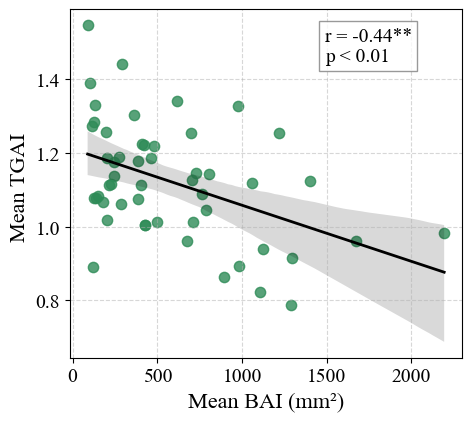

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
df_TGAI = pd.read_csv(r"../Rawdat/site52.csv")
trend_df['Site'] = trend_df['Site'].str.strip().str.lower()
df_TGAI['site'] = df_TGAI['site'].str.strip().str.lower()
df_merge = pd.merge(trend_df, df_TGAI, left_on='Site', right_on='site', how='inner')
dfCS = df_merge.dropna(subset=['Mean', 'Mean_BAI'])
r, p = stats.pearsonr(dfCS['Mean'], dfCS['Mean_BAI'])

if p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = 'ns'

plt.figure(figsize=(5,4.5))


sns.regplot(
    data=dfCS,
    x='Mean_BAI', y='Mean',
    scatter_kws={'s': 55, 'color': 'seagreen', 'alpha': 0.8},
    line_kws={'color': 'black', 'lw': 2},
    ci=95
)

text = f"r = {r:.2f}{sig}\n" + (f"p < 0.01" if p < 0.01 else f"p = {p:.3f}")
plt.text(
    0.65, 0.85, text,
    transform=plt.gca().transAxes,
    fontsize=14,
    fontfamily="Times New Roman",
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
)


plt.ylabel("Mean TGAI ")
plt.xlabel("Mean BAI (mm²)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig(r"../Rawdata/Fig/Fig3C-TGAI_MeanBAI_overall.jpg", dpi=600)
plt.show()



===  Pearson  ===
    Zone         r         p
0   Arid -0.694002  0.001998
1  Humid -0.482144  0.003357

=== ANCOVA===
                    sum_sq    df          F    PR(>F)
C(Zone)           0.133163   1.0   7.175831  0.010089
Mean_BAI          0.305286   1.0  16.451050  0.000183
Mean_BAI:C(Zone)  0.005992   1.0   0.322878  0.572532
Residual          0.890747  48.0        NaN       NaN


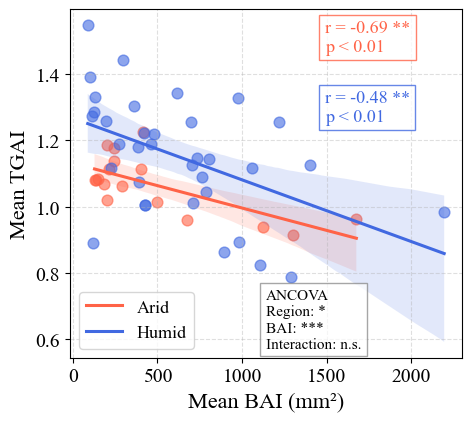

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm


df = df_merge.dropna(subset=['Mean', 'Mean_BAI', 'ai_v3']).copy()
df['Zone'] = np.where(df['ai_v3'] <= 0.65, 'Arid', 'Humid')


stats_list = []
for zone, sub in df.groupby('Zone'):
    r, p = stats.pearsonr(sub['Mean'], sub['Mean_BAI'])
    stats_list.append({'Zone': zone, 'r': r, 'p': p})
stats_df = pd.DataFrame(stats_list)
print("\n===  Pearson  ===")
print(stats_df)


model = smf.ols("Mean ~ Mean_BAI * C(Zone)", data=df).fit()
ancova_res = anova_lm(model, typ=2)
print("\n=== ANCOVA===")
print(ancova_res)


p_zone = ancova_res.loc['C(Zone)', 'PR(>F)']
p_bai  = ancova_res.loc['Mean_BAI', 'PR(>F)']
p_inter = ancova_res.loc['Mean_BAI:C(Zone)', 'PR(>F)']

def signif(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'n.s.'
def p_to_label(p):
    if p < 0.001:
        return "***", "p < 0.001"
    elif p < 0.01:
        return "**", "p < 0.01"
    elif p < 0.05:
        return "*", "p < 0.05"
    else:
        return "n.s.", "n.s."
ancova_text = (
    "ANCOVA\n"
    f"Region: {signif(p_zone)}\n"
    f"BAI: {signif(p_bai)}\n"
    f"Interaction: {signif(p_inter)}"
)



plt.figure(figsize=(5, 4.5))
palette = {'Arid': 'tomato', 'Humid': 'royalblue'}


sns.regplot(
    data=df[df['Zone'] == 'Arid'],
    x='Mean_BAI', y='Mean',
    scatter_kws={'s': 60, 'color': 'tomato', 'alpha': 0.6},
    line_kws={'color': 'tomato', 'lw': 2.2},
    ci=95
)


sns.regplot(
    data=df[df['Zone'] == 'Humid'],
    x='Mean_BAI', y='Mean',
    scatter_kws={'s': 60, 'color': 'royalblue', 'alpha': 0.6},
    line_kws={'color': 'royalblue', 'lw': 2.2},
    ci=95
)


for i, row in stats_df.iterrows():
    zone, r37, p37 = row['Zone'], row['r'], row['p']

    sig, p_label = p_to_label(p37)
    text = f"r = {r37:.2f} {sig}\n{p_label}"

    if zone == "Arid":
        plt.text(
            0.65, 0.88, text,
            transform=plt.gca().transAxes,
            fontsize=13, color='tomato',
            bbox=dict(facecolor='white', edgecolor='tomato', alpha=0.8)
        )
    else:
        plt.text(
            0.65, 0.68, text,
            transform=plt.gca().transAxes,
            fontsize=13, color='royalblue',
            bbox=dict(facecolor='white', edgecolor='royalblue', alpha=0.8)
        )


plt.text(
    0.5, 0.02, ancova_text,
    transform=plt.gca().transAxes,
    fontsize=11,
    va='bottom', ha='left',
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
)

plt.ylabel("Mean TGAI")
plt.xlabel("Mean BAI (mm²)")
plt.yticks([0.6, 0.8, 1.0, 1.2, 1.4])
plt.xticks([0, 500, 1000, 1500, 2000])
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.legend(labels=['Arid', 'Humid'], loc=3, fontsize=13)

# plt.savefig(r"../Rawdata/Fig/Fig3D——TGAI_BAI_ClimateZone.jpg", dpi=600)
plt.show()


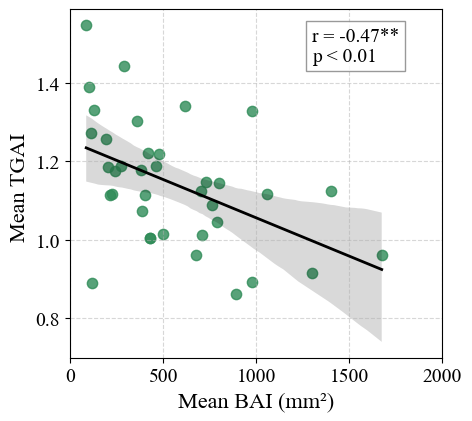

In [40]:
df_TGAI5 = pd.read_csv(r"../Rawdat/site_37.csv")
trend_df['Site'] = trend_df['Site'].str.strip().str.lower()
df_TGAI5['site'] = df_TGAI5['site'].str.strip().str.lower()

df_merge37 = pd.merge(trend_df, df_TGAI5, left_on='Site', right_on='site', how='inner')


dfCS = df_merge37.dropna(subset=['Mean', 'Mean_BAI'])
r, p = stats.pearsonr(dfCS['Mean'], dfCS['Mean_BAI'])

if p < 0.001:
    sig = '***'
elif p < 0.01:
    sig = '**'
elif p < 0.05:
    sig = '*'
else:
    sig = 'ns'

plt.figure(figsize=(5,4.5))


sns.regplot(
    data=dfCS,
    x='Mean_BAI', y='Mean',
    scatter_kws={'s': 55, 'color': 'seagreen', 'alpha': 0.8},
    line_kws={'color': 'black', 'lw': 2},
    ci=95
)

text = f"r = {r:.2f}{sig}\n" + (f"p < 0.01" if p < 0.01 else f"p = {p:.3f}")
plt.text(
    0.65, 0.85, text,
    transform=plt.gca().transAxes,
    fontsize=14,
    fontfamily="Times New Roman",
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
)


plt.ylabel("Mean TGAI ")
plt.yticks([0.8,1.0,1.2,1.4])
plt.xticks([0,500,1000,1500,2000])
plt.xlabel("Mean BAI (mm²)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig(r"../Rawdata/Fig/FigS8C-TGAI_MeanBAI_overall.jpg", dpi=600)
plt.show()



=== Pearson  ===
    Zone         r         p
0   Arid -0.817299  0.013234
1  Humid -0.409284  0.027475

=== ANCOVA ===
                    sum_sq    df         F    PR(>F)
C(Zone)           0.049529   1.0  2.484857  0.124486
Mean_BAI          0.176924   1.0  8.876255  0.005386
Mean_BAI:C(Zone)  0.002270   1.0  0.113897  0.737888
Residual          0.657767  33.0       NaN       NaN


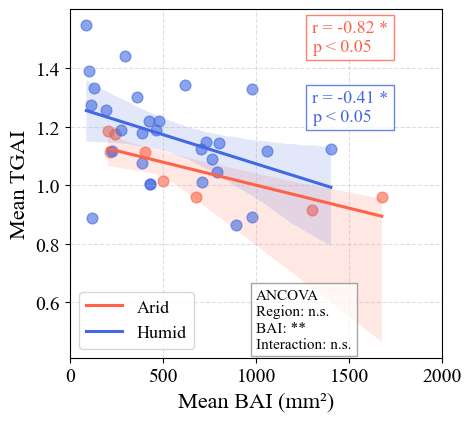

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm


df = df_merge37.dropna(subset=['Mean', 'Mean_BAI', 'ai_v3']).copy()
df['Zone'] = np.where(df['ai_v3'] <= 0.65, 'Arid', 'Humid')


stats_list = []
for zone, sub in df.groupby('Zone'):
    r, p = stats.pearsonr(sub['Mean'], sub['Mean_BAI'])
    stats_list.append({'Zone': zone, 'r': r, 'p': p})
stats_df = pd.DataFrame(stats_list)
print("\n=== Pearson  ===")
print(stats_df)


model = smf.ols("Mean ~ Mean_BAI * C(Zone)", data=df).fit()
ancova_res = anova_lm(model, typ=2)
print("\n=== ANCOVA ===")
print(ancova_res)


p_zone = ancova_res.loc['C(Zone)', 'PR(>F)']
p_bai  = ancova_res.loc['Mean_BAI', 'PR(>F)']
p_inter = ancova_res.loc['Mean_BAI:C(Zone)', 'PR(>F)']

def signif(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'n.s.'
def p_to_label(p):
    if p < 0.001:
        return "***", "p < 0.001"
    elif p < 0.01:
        return "**", "p < 0.01"
    elif p < 0.05:
        return "*", "p < 0.05"
    else:
        return "n.s.", "n.s."
ancova_text = (
    "ANCOVA\n"
    f"Region: {signif(p_zone)}\n"
    f"BAI: {signif(p_bai)}\n"
    f"Interaction: {signif(p_inter)}"
)



plt.figure(figsize=(5, 4.5))
palette = {'Arid': 'tomato', 'Humid': 'royalblue'}


sns.regplot(
    data=df[df['Zone'] == 'Arid'],
    x='Mean_BAI', y='Mean',
    scatter_kws={'s': 60, 'color': 'tomato', 'alpha': 0.6},
    line_kws={'color': 'tomato', 'lw': 2.2},
    ci=95
)


sns.regplot(
    data=df[df['Zone'] == 'Humid'],
    x='Mean_BAI', y='Mean',
    scatter_kws={'s': 60, 'color': 'royalblue', 'alpha': 0.6},
    line_kws={'color': 'royalblue', 'lw': 2.2},
    ci=95
)


for i, row in stats_df.iterrows():
    zone, r37, p37 = row['Zone'], row['r'], row['p']

    sig, p_label = p_to_label(p37)
    text = f"r = {r37:.2f} {sig}\n{p_label}"

    if zone == "Arid":
        plt.text(
            0.65, 0.88, text,
            transform=plt.gca().transAxes,
            fontsize=13, color='tomato',
            bbox=dict(facecolor='white', edgecolor='tomato', alpha=0.8)
        )
    else:
        plt.text(
            0.65, 0.68, text,
            transform=plt.gca().transAxes,
            fontsize=13, color='royalblue',
            bbox=dict(facecolor='white', edgecolor='royalblue', alpha=0.8)
        )


plt.text(
    0.5, 0.02, ancova_text,
    transform=plt.gca().transAxes,
    fontsize=11,
    va='bottom', ha='left',
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
)

plt.ylabel("Mean TGAI")
plt.xlabel("Mean BAI (mm²)")
plt.yticks([0.6, 0.8, 1.0, 1.2, 1.4])
plt.xticks([0, 500, 1000, 1500, 2000])
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.legend(labels=['Arid', 'Humid'], loc=3, fontsize=13)

# plt.savefig(r"../Rawdata/Fig/Fig8D-TGAI_BAI_ClimateZone_ANCOVA.jpg", dpi=600)
plt.show()
